reading the raw data    

In [1]:
import mne
mne.set_log_level('error')

#participant id
p_id='sub-001'
data_dir = 'data/' + p_id + '/'

file_name_raw = data_dir + p_id + '-raw-arg.fif'
raw = mne.io.read_raw_fif(file_name_raw,preload=True)
raw.set_montage("easycap-M1")


Measurement date,"January 20, 2015 13:15:58 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,19 points
Good channels,16 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,500.00 Hz
Highpass,0.01 Hz
Lowpass,80.00 Hz


for ica we filter with a higher low cut to remove the i/f law of low drift higher variance . we will reapply this correction to the original data back again to remove the artefacts.

In [2]:
#filter settings
ica_low_cut = 1.0
hi_cut = 30

raw_ica = raw.copy().filter(ica_low_cut,hi_cut)
raw_ica.info



Measurement date,"January 20, 2015 13:15:58 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,19 points
Good channels,16 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,500.00 Hz
Highpass,1.00 Hz
Lowpass,30.00 Hz


break raw_ica data into epochs of 1s segments

In [3]:
tstep = 1.0
events_ica = mne.make_fixed_length_events(raw_ica,duration=tstep)
epochs_ica = mne.Epochs(raw_ica,events_ica,tmin=0.01,tmax=tstep,baseline=None,preload=True)

autoreject use to mark big variance excessively noisy sections in the data like sneezes or head sctratches

In [4]:
!pip list

Package                       Version
----------------------------- -----------
accessible-pygments           0.0.5
alabaster                     0.7.16
asttokens                     2.4.1
attrs                         23.2.0
autoreject                    0.4.3
Babel                         2.15.0
beautifulsoup4                4.12.3
certifi                       2024.6.2
charset-normalizer            3.3.2
click                         8.1.7
comm                          0.2.2
contourpy                     1.2.1
cycler                        0.12.1
debugpy                       1.8.2
decorator                     5.1.1
docutils                      0.20.1
exceptiongroup                1.2.1
executing                     2.0.1
fastjsonschema                2.20.0
fonttools                     4.53.0
greenlet                      3.0.3
h5io                          0.2.3
h5py                          3.11.0
idna                          3.7
imagesize                     1.4.1
importlib_

In [5]:
from autoreject import AutoReject
ar = AutoReject(n_interpolate = [1,2,4],
                random_state=42,
                picks=mne.pick_types(epochs_ica.info,eeg=True,eog=False),
                n_jobs=1,
                verbose=False)
ar.fit(epochs_ica)
reject_log = ar.get_reject_log(epochs_ica)

plotting the reject log

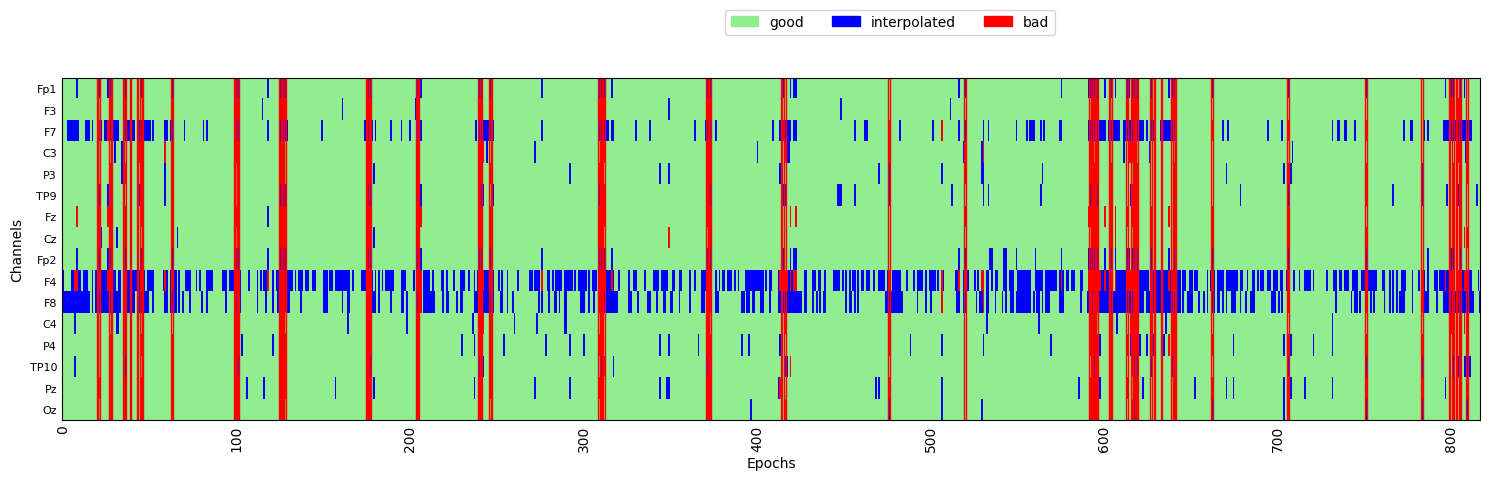

In [6]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize=[15,5])
reject_log.plot('horizontal',ax=ax,aspect="auto")
plt.show()

finding the components by rejecting the bad epochs


In [7]:
#paramets
ica_n_components = 0.99
random_state = 42

#fit ica
#build ica
ICA = mne.preprocessing.ICA(n_components=ica_n_components,
                            random_state=random_state,
                            )
ICA.fit(epochs_ica[~reject_log.bad_epochs],decim=3)

Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,20 iterations on epochs (124998 samples)
ICA components,13
Available PCA components,16
Channel types,eeg
ICA components marked for exclusion,—


visualise properties of ICA components via different plots

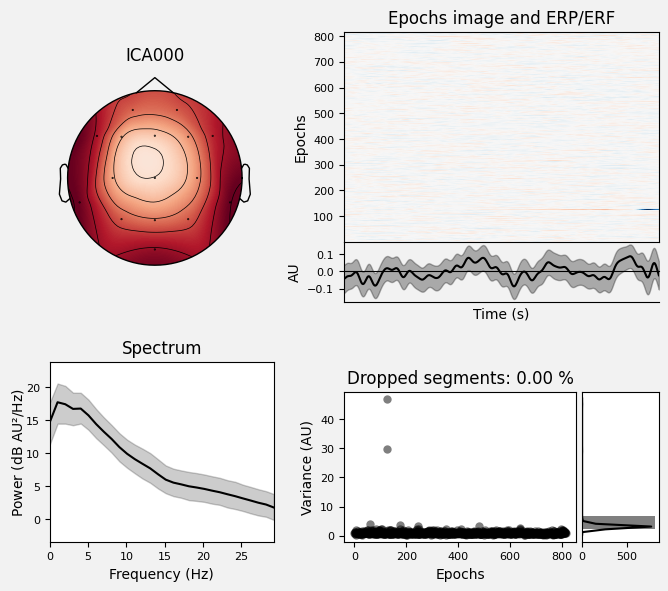

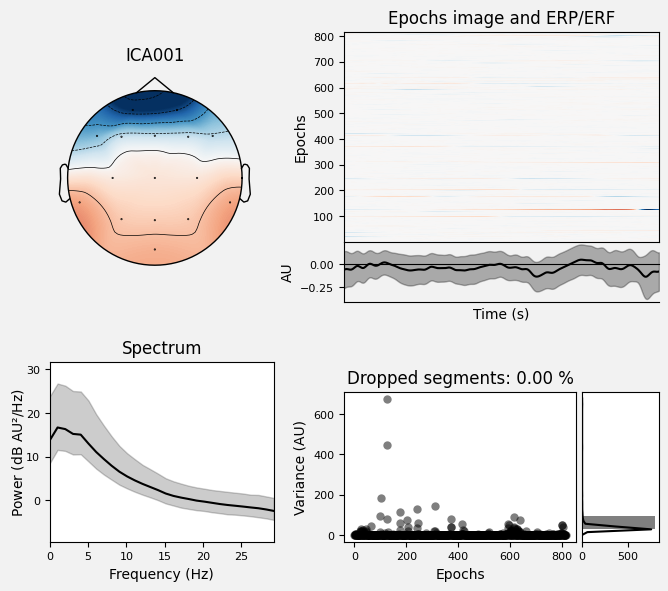

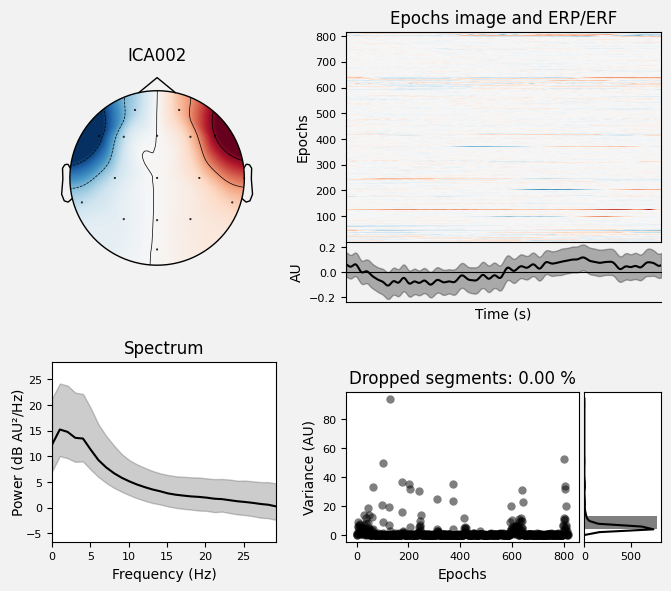

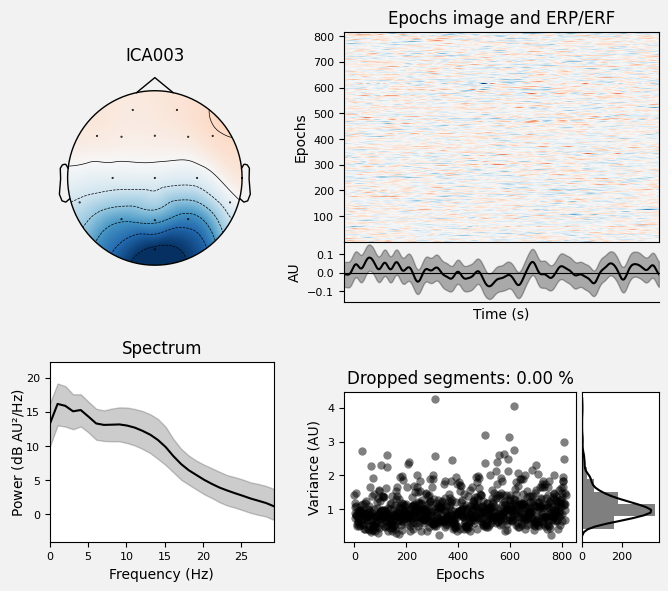

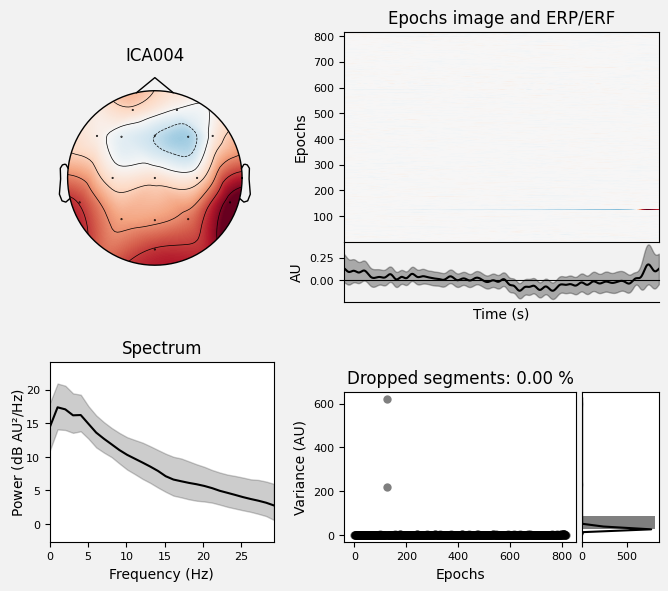

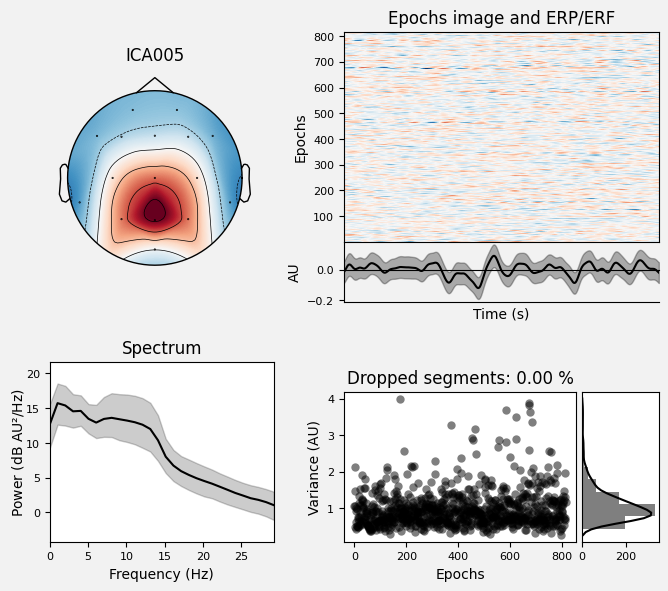

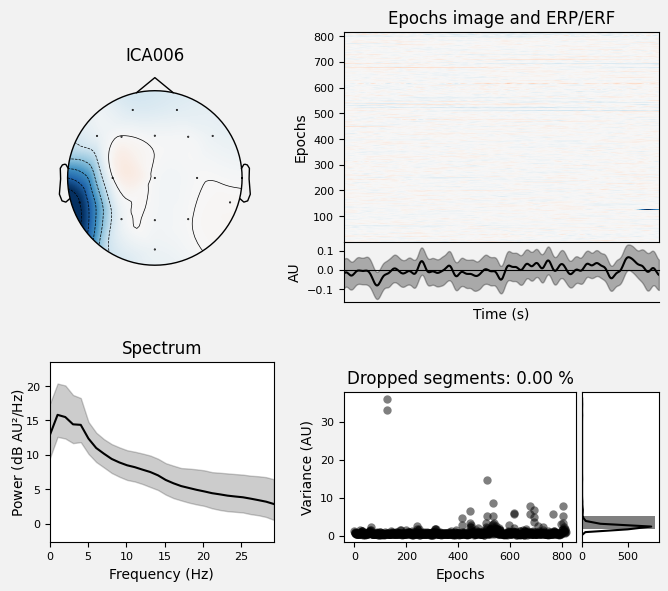

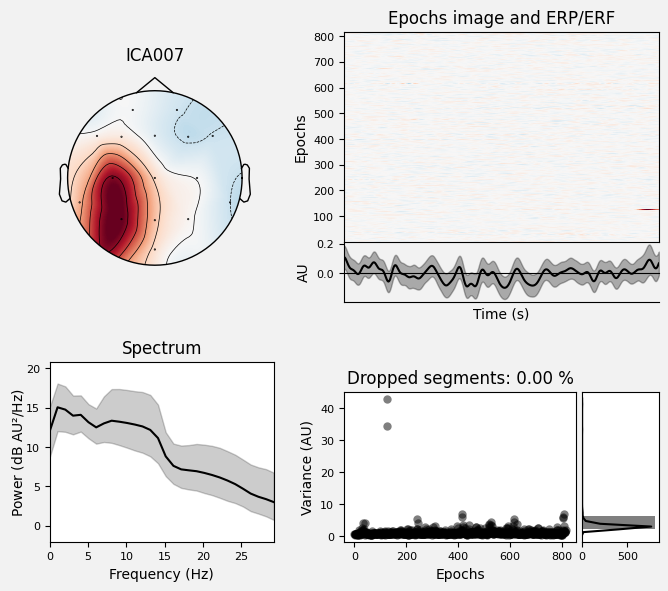

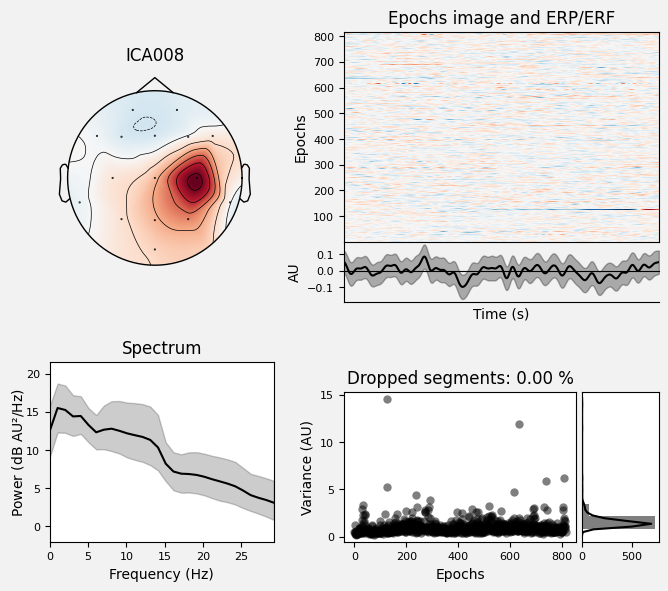

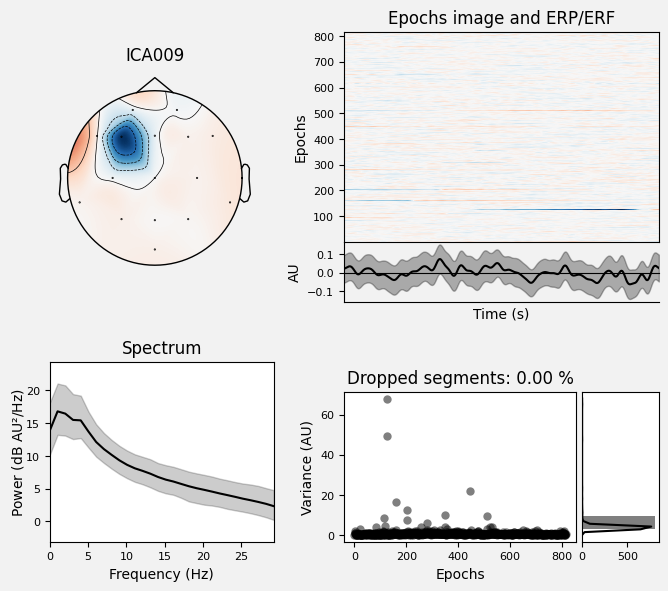

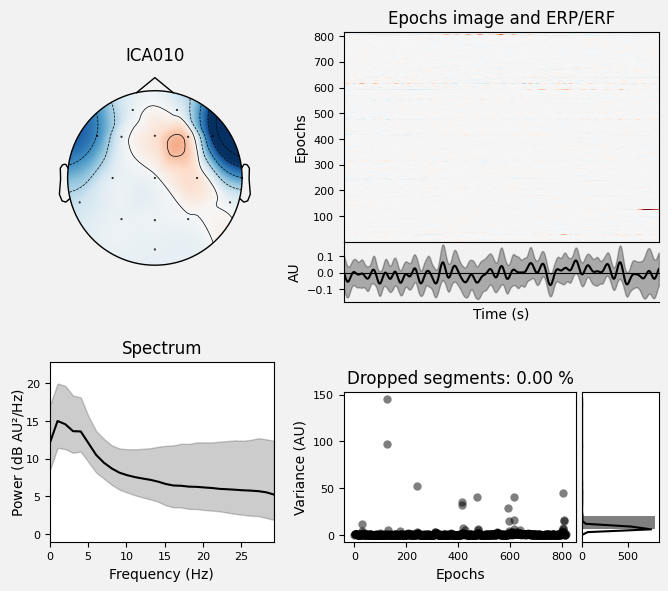

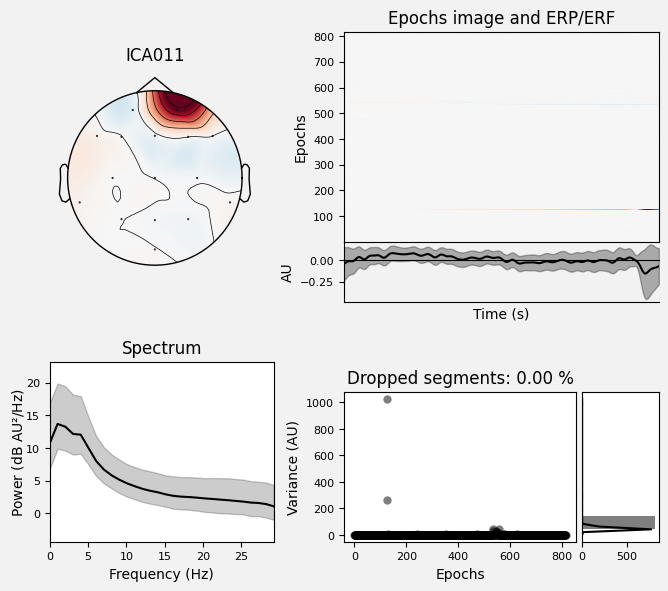

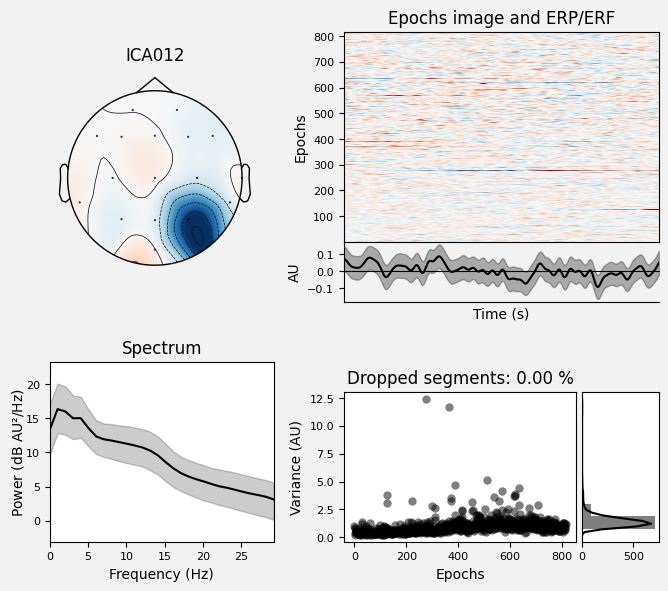

[<Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>]

In [11]:
ICA.plot_properties(epochs_ica,picks=range(0,ICA.n_components_),psd_args=dict(fmax=hi_cut))

Find and remove EOG (electrooculogram) artefacts from the data


In [15]:
max_eog = 2
num_excl = 0
ica_excl = []
z_thresh = 3.5
z_step =0.1

while num_excl < max_eog:
    eog_indices,eog_scores = ICA.find_bads_eog(epochs_ica,ch_name=['Fp1','Fp2','F7','F8'],
                                          threshold=z_thresh)
    z_thresh -= z_step
    num_excl =len(eog_indices)

ica_excl = eog_indices

print("Excluded components are " ,ica_excl)
print("Final threshold is " + str(z_thresh))

    





Excluded components are  [np.int64(1), np.int64(2), np.int64(0)]
Final threshold is 2.199999999999999


plotting correlations of components and mark the ones that are rejected

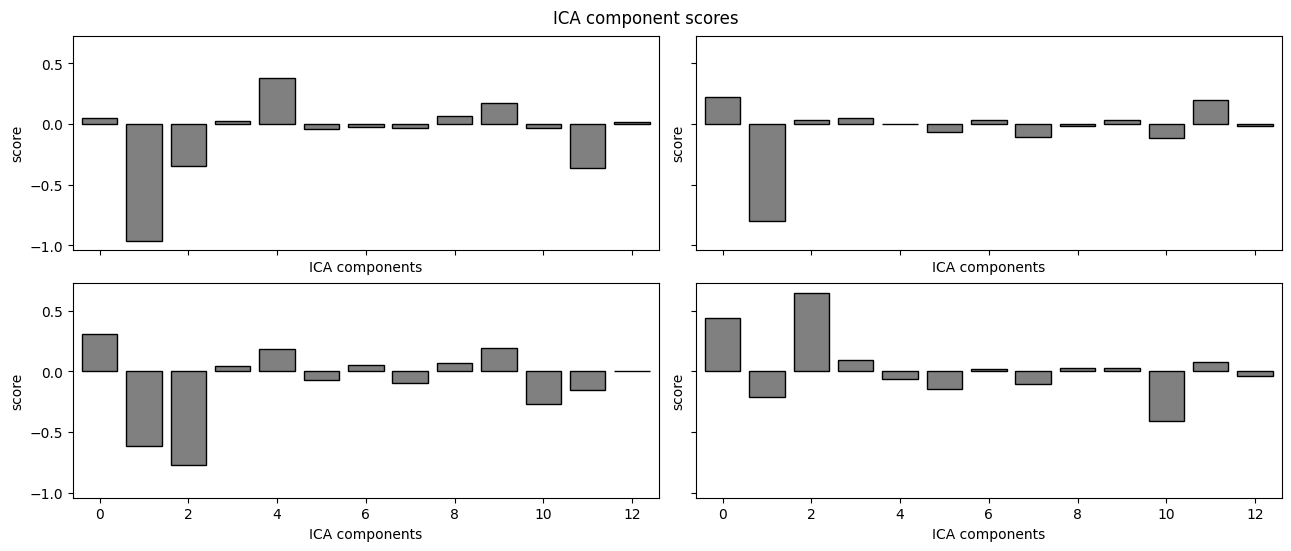

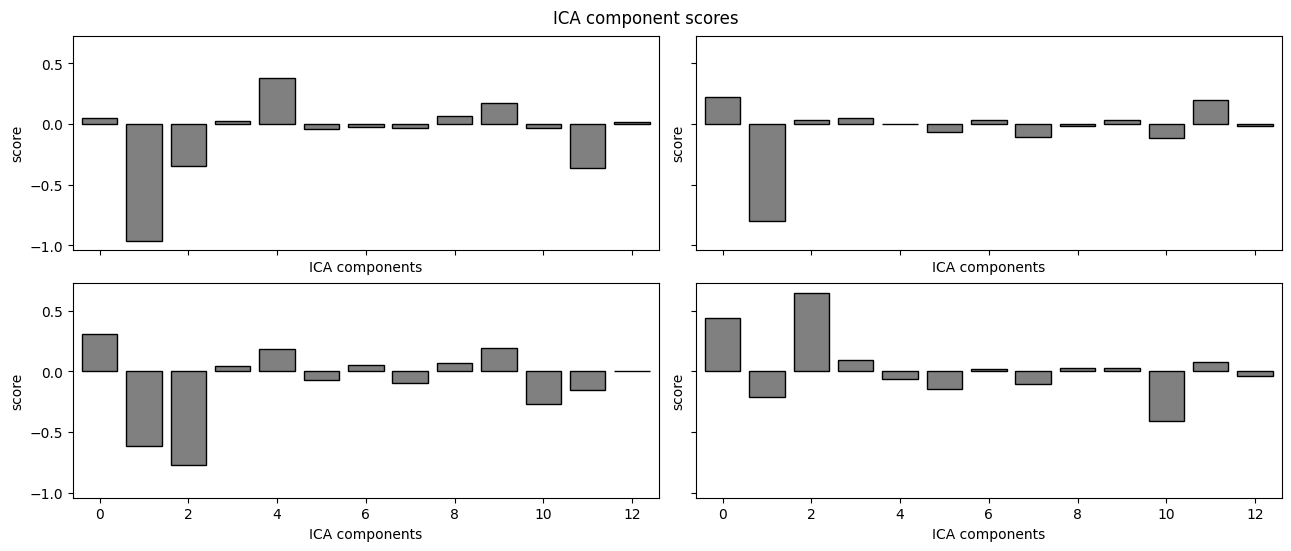

In [16]:
ICA.plot_scores(eog_scores)

saving the ica file in fif format -> fif is digital vector graphics format with fractals so prolly for the graphics that we made in the code or sth

In [17]:
ICA.save(data_dir + p_id + '-ica-arg.fif',overwrite=True)

Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,20 iterations on epochs (124998 samples)
ICA components,13
Available PCA components,16
Channel types,eeg
ICA components marked for exclusion,—
